# The Ultimate Algo Trader (Neurobot 1.0)

## Introduction:
This jupyter notebook contains code for developing and testing an algorithmic trader based on Python and Machine learning strategy.

## Steps:
1. **Data preperation**: Access historical market data via Alpaca API and preprocess it for analysis.
2. **Strategy**: Develop algorithmic trading strategies and instantiate LSTM model.
3. **Backtesting-Risk/Reward**: Backtest the strategy using historical data and calculate both the risk and the reward metrics
4. **live Trading(Optional)**: Implement the strategy for paper trading on Alpaca via API.

#### Notes: 
- This notebook is for educational and experimental purposes only.

### Imports and Dependencies

In [1]:
import os
import numpy as np
import random
import datetime
import pandas as pd
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from scipy.interpolate import interp1d
from alpaca_trade_api.rest import REST, TimeFrame
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
import pandas_ta as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from finta import TA
import holoviews as hv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from keras.losses import MeanAbsolutePercentageError
from keras.losses import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# Initialize python files and import functions
import stock_data as data
import algo_strategy as strategy
import backtesting as backtest
import feature_list as feature

import warnings
warnings.filterwarnings('ignore')


In [2]:
load_dotenv()

True

In [3]:
# Set API credentials
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

# ticker list based on monthly highest dollar volume rank(liquidity) 
#tickers_list = data.get_top_tickers(sp500_url = os.getenv("SP500_URL"))
#tickers = [ticker[1] for ticker in tickers_list]
tickers = ['META']
# Call the function to fetch stock data
stock_data = data.fetch_stock_data(tickers, alpaca_api_key, alpaca_secret_key, base_url)
stock_df = stock_data

In [4]:
display(tickers)

['META']

In [5]:
display(stock_df)

,symbol,open,high,low,close,volume
timestamp,,,,,,
2016-03-01 09:00:00+00:00,META,107.9900,107.9900,107.56,107.56,1250
2016-03-01 10:00:00+00:00,META,107.8800,107.8800,107.88,107.88,114
2016-03-01 11:00:00+00:00,META,107.8700,108.0000,107.77,107.80,5058
2016-03-01 12:00:00+00:00,META,107.9000,108.2000,107.88,108.00,25892
2016-03-01 13:00:00+00:00,META,107.9600,108.1500,107.75,107.95,89266
...,...,...,...,...,...,...
2024-03-19 19:00:00+00:00,META,493.5300,496.6296,492.69,495.81,1725979
2024-03-19 20:00:00+00:00,META,496.2400,496.3300,495.30,495.87,2235567
2024-03-19 21:00:00+00:00,META,496.2400,496.2400,495.87,496.12,7665


#### Feauture Engineering

In [6]:
stock_df = feature.calculate_pct_change(stock_df)

In [7]:
stock_df = feature.cumulative_returns(stock_df)

In [8]:
stock_df = feature.simple_moving_averge(stock_df)

In [9]:
stock_df = feature.sma_ema_long_short(stock_df)

In [10]:
stock_df = feature.standard_deviation(stock_df)

In [11]:
stock_df = feature.calculate_bollinger_bands(stock_df)

In [12]:
stock_df = feature.finta_technical_indicators(stock_df)

### Data Processing and Cleaning

In [13]:
# Drop NAN values and display stock_df
stock_df.dropna(inplace=True)
display(stock_df.head())
display(stock_df.tail())


,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,SMA100,STD,Upper Band,Lower Band,TA Short,TA Long
timestamp,,,,,,,,,,,,,,,,
2016-03-09 19:00:00+00:00,META,107.1759,107.46,107.11,107.35,1986327,0.001586,0.998048,106.49322,106.697050,108.051254,0.482460,107.458140,105.528300,106.424800,106.697050
2016-03-09 20:00:00+00:00,META,107.3500,107.51,107.03,107.50,2897320,0.001397,0.999442,106.54322,106.668850,108.050654,0.532430,107.608079,105.478361,106.529467,106.668850
2016-03-09 21:00:00+00:00,META,107.5100,107.60,107.49,107.57,952827,0.000651,1.000093,106.56910,106.652250,108.047554,0.569753,107.708607,105.429593,106.634133,106.652250
2016-03-09 22:00:00+00:00,META,107.5700,107.57,107.52,107.53,3351,-0.000372,0.999721,106.60760,106.624776,108.044854,0.608060,107.823720,105.391480,106.739473,106.624776
2016-03-09 23:00:00+00:00,META,107.5400,107.58,107.53,107.53,13231,0.000000,0.999721,106.63910,106.597176,108.040154,0.639510,107.918120,105.360080,106.841473,106.597176


,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,SMA100,STD,Upper Band,Lower Band,TA Short,TA Long
timestamp,,,,,,,,,,,,,,,,
2024-03-19 19:00:00+00:00,META,493.5300,496.6296,492.69,495.81,1725979,0.004579,4.609613,493.645755,490.668016,492.562434,2.893448,499.432650,487.858860,493.293120,490.668016
2024-03-19 20:00:00+00:00,META,496.2400,496.3300,495.30,495.87,2235567,0.000121,4.610171,493.835005,490.744616,492.653534,2.909727,499.654459,488.015551,493.284453,490.744616
2024-03-19 21:00:00+00:00,META,496.2400,496.2400,495.87,496.12,7665,0.000504,4.612495,493.966005,490.830016,492.754934,2.952514,499.871034,488.060976,493.291787,490.830016
2024-03-19 22:00:00+00:00,META,496.1984,496.1984,496.00,496.00,3039,-0.000242,4.611380,494.056390,490.902416,492.853884,2.987271,500.030933,488.081847,493.337120,490.902416
2024-03-19 23:00:00+00:00,META,496.0100,496.6700,496.01,496.51,4933,0.001028,4.616121,494.027390,490.992616,492.981184,2.958953,499.945295,488.109485,493.474453,490.992616


### Algorithim Buy/Sell  Best signal selection

In [14]:
simple_momentum = strategy.simple_momentum(stock_df)
dmac= strategy.dmac_strategy(stock_df)
finta_strategy = strategy.finta_strategy(stock_df)
bollinger_bands = strategy.bollinger_bands_strategy(stock_df)
pairs_trading = strategy.pairs_trading_signals(stock_df, entry_threshold=1.0, exit_threshold=0.5)

signal_one = stock_df['Signal_SM']
signal_two = stock_df['Signal_DMAC']
signal_three = stock_df['Signal_FINTA']
signal_four = stock_df['Signal_BB']
signal_five = stock_df['Signal_PTS']

# Create a list of lists containing signals for each asset
signals = [signal_one, signal_two, signal_three, signal_four, signal_five]

# Call the majority_vote function with the list of signals
majority_signals = strategy.majority_vote(signals)

# Add the majority signals as a new column to the existing stock_df DataFrame
stock_df['Signal'] = majority_signals

# Add entry and exit columns for plotting entry and exit points
stock_df['entry'] = stock_df['Signal'].apply(lambda x: 1 if x == 1 else 0)
stock_df['exit'] = stock_df['Signal'].apply(lambda x: -1 if x == -1 else 0)

# Display the updated stock_df DataFrame
stock_df

,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,...,TA Long,Signal_SM,Signal_DMAC,Signal_FINTA,Signal_BB,Spread,Signal_PTS,Signal,entry,exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-03-09 19:00:00+00:00,META,107.1759,107.4600,107.11,107.35,1986327,0.001586,0.998048,106.493220,106.697050,...,106.697050,1.0,0.0,0.0,0.0,0.1741,0,1,1,0
2016-03-09 20:00:00+00:00,META,107.3500,107.5100,107.03,107.50,2897320,0.001397,0.999442,106.543220,106.668850,...,106.668850,1.0,0.0,0.0,0.0,0.1500,0,1,1,0
2016-03-09 21:00:00+00:00,META,107.5100,107.6000,107.49,107.57,952827,0.000651,1.000093,106.569100,106.652250,...,106.652250,1.0,0.0,0.0,0.0,0.0600,0,1,1,0
2016-03-09 22:00:00+00:00,META,107.5700,107.5700,107.52,107.53,3351,-0.000372,0.999721,106.607600,106.624776,...,106.624776,-1.0,0.0,0.0,0.0,-0.0400,0,-1,0,-1
2016-03-09 23:00:00+00:00,META,107.5400,107.5800,107.53,107.53,13231,0.000000,0.999721,106.639100,106.597176,...,106.597176,1.0,0.0,0.0,0.0,-0.0100,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19 19:00:00+00:00,META,493.5300,496.6296,492.69,495.81,1725979,0.004579,4.609613,493.645755,490.668016,...,490.668016,1.0,0.0,1.0,0.0,2.2800,1,1,1,0
2024-03-19 20:00:00+00:00,META,496.2400,496.3300,495.30,495.87,2235567,0.000121,4.610171,493.835005,490.744616,...,490.744616,1.0,0.0,1.0,0.0,-0.3700,0,1,1,0
2024-03-19 21:00:00+00:00,META,496.2400,496.2400,495.87,496.12,7665,0.000504,4.612495,493.966005,490.830016,...,490.830016,1.0,0.0,1.0,0.0,-0.1200,0,1,1,0


In [15]:
# Calculate the strategy returns and add them to the stock_df DataFrame
Strategy_Returns = feature.calculate_strategy_returns(stock_df)

# Plot Strategy Returns to examine performance
plot = (1 + stock_df['Strategy Returns']).cumprod().hvplot()

In [16]:
original = stock_df['Cumulative Returns'].hvplot()

In [17]:
original * plot

:Overlay
   .Curve.Cumulative_Returns :Curve   [timestamp]   (Cumulative Returns)
   .Curve.Strategy_Returns   :Curve   [timestamp]   (Strategy Returns)

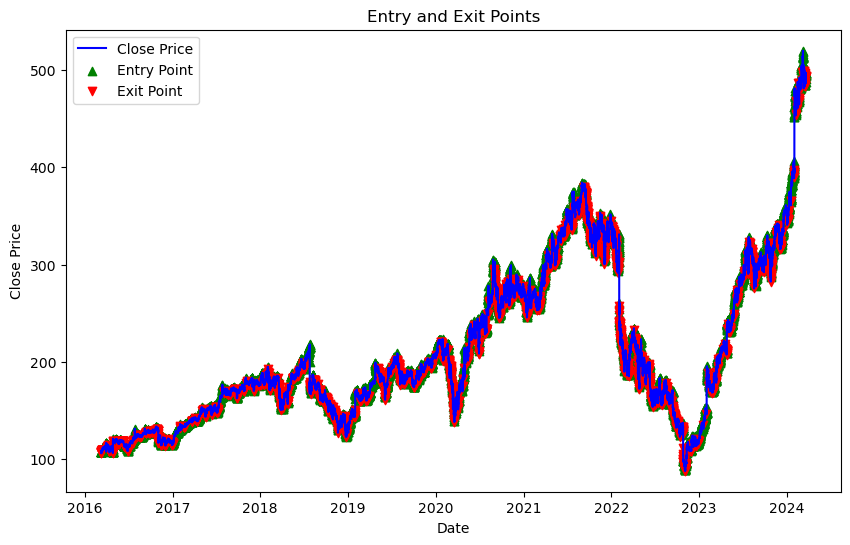

In [18]:
# Plot close price, entry, and exit points
plt.figure(figsize=(10, 6))
plt.plot(stock_df.index, stock_df['close'], label='Close Price', color='b')
plt.scatter(stock_df.index[stock_df['entry'] == 1], stock_df['close'][stock_df['entry'] == 1], marker='^', color='green', label='Entry Point')
plt.scatter(stock_df.index[stock_df['exit'] == -1], stock_df['close'][stock_df['exit'] == -1], marker='v', color='red', label='Exit Point')
plt.title('Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [20]:
# Calculate position
stock_df = backtest.calculate_position(stock_df)

# Calculate entry-exit position
stock_df = backtest.calculate_entry_exit_position(stock_df)

# Calculate Portfolio holdings 
stock_df = backtest.calculate_portfolio_holdings(stock_df)

# Calculate Cash returns
stock_df = backtest.calculate_cash_returns(stock_df)

portfolio_metric = backtest.portfolio_metrics(stock_df)

portfolio_metric

# Calculate trade evaluation inplace
#trade_evaluation = backtest.trade_evaluation(stock_df)
#trade_evaluation

,Strategy Backtest
Annualized Return,0.058936
Cumulative Returns,-2.133743
Annual Volatility,0.437293
Sharpe Ratio,0.089038
Sortino Ratio,0.233913


In [21]:
stock_df.dropna()

,symbol,open,high,low,close,volume,Daily Returns,Cumulative Returns,SMA20,SMA50,...,entry,exit,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-03-09 21:00:00+00:00,META,107.5100,107.6000,107.49,107.57,952827,0.000651,1.000093,106.569100,106.652250,...,1,0,0.000651,3000,0.0,322710.0,100000.0,422710.0,0.000497,0.000497
2016-03-09 22:00:00+00:00,META,107.5700,107.5700,107.52,107.53,3351,-0.000372,0.999721,106.607600,106.624776,...,0,-1,-0.000372,-3000,-6000.0,-322590.0,745180.0,422590.0,-0.000284,0.000213
2016-03-09 23:00:00+00:00,META,107.5400,107.5800,107.53,107.53,13231,0.000000,0.999721,106.639100,106.597176,...,1,0,-0.000000,3000,6000.0,322590.0,100000.0,422590.0,0.000000,0.000213
2016-03-10 00:00:00+00:00,META,107.5300,107.5800,107.47,107.57,7725,0.000372,1.000093,106.703600,106.569148,...,1,0,0.000372,3000,0.0,322710.0,100000.0,422710.0,0.000284,0.000497
2016-03-10 10:00:00+00:00,META,107.7200,107.7200,107.62,107.62,665,0.000465,1.000558,106.788100,106.558728,...,1,0,0.000465,3000,0.0,322860.0,100000.0,422860.0,0.000355,0.000852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19 19:00:00+00:00,META,493.5300,496.6296,492.69,495.81,1725979,0.004579,4.609613,493.645755,490.668016,...,1,0,-0.004579,3000,6000.0,1487430.0,-1967006.6,-479576.6,0.014340,-2.135093
2024-03-19 20:00:00+00:00,META,496.2400,496.3300,495.30,495.87,2235567,0.000121,4.610171,493.835005,490.744616,...,1,0,0.000121,3000,0.0,1487610.0,-1967006.6,-479396.6,-0.000375,-2.134667
2024-03-19 21:00:00+00:00,META,496.2400,496.2400,495.87,496.12,7665,0.000504,4.612495,493.966005,490.830016,...,1,0,0.000504,3000,0.0,1488360.0,-1967006.6,-478646.6,-0.001564,-2.132891


### Train Test Split

In [22]:
# Setting x and y labels

X = stock_df.drop(columns=["symbol","Signal"]).shift().dropna().copy()

# Create y containing only the "Signal" column
y = stock_df["Signal"].copy()

# Determine the start and end dates for training
training_begin = X.index.min()
training_end = X.index.min() + DateOffset(months=76)

# Update the training and testing sets based on the determined period using boolean indexing
X_train = X[(X.index >= training_begin) & (X.index <= training_end)]
y_train = y[(y.index >= training_begin) & (y.index <= training_end)]
X_test = X[X.index >= (training_end + DateOffset(hours=1))]
y_test = y[y.index > (training_end + DateOffset(hours=1))]


### Standardize The Data

In [23]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
X_train_scaled

array([[-1.39208131, -1.39512734, -1.38763451, ...,  0.57207253,
         0.00593736,  0.57207253],
       [-1.39119899, -1.39556702, -1.38719184, ...,  0.57176294,
        -0.01935465,  0.57176294],
       [-1.39164015, -1.39542046, -1.38704428, ...,  0.57176294,
        -0.01016046,  0.57176294],
       ...,
       [-0.46682021, -0.45694305, -0.46292506, ..., -2.63604613,
        -0.13950347, -2.63604613],
       [-0.45035021, -0.4555126 , -0.45624063, ..., -2.64113121,
         0.06761446, -2.64113121],
       [-0.46034985, -0.46592001, -0.45343701, ..., -2.64041759,
        -0.02104885, -2.64041759]])

### PCA - dimension reduction

In [25]:
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) 


X_train_pca[:5]



array([[-4.8736486 , -0.91622679, -0.57689399],
       [-5.0858939 ,  3.72085751, -2.13497979],
       [-4.84924715, -1.43922179, -0.36780995],
       [-4.86354011, -0.90379119, -0.50522095],
       [-4.86013569, -0.88024095, -0.47266471]])

### Machine Learning LSTM Model

##### Data reshape

In [35]:
# Reshape X_train to include the time step dimension
timesteps = 6500

X_train_reshaped = np.array([X_train_pca[i:i+timesteps] for i in range(len(X_train_pca) - timesteps + 1)])
y_train_reshaped = y_train[timesteps - 1:]  # Adjust y_train accordingly

# Reshape X_test to include the time step dimension
X_test_reshaped = np.array([X_test_pca[i:i+timesteps] for i in range(len(X_test_pca) - timesteps + 1)])
y_test_reshaped = y_test[timesteps - 1:]  # Adjust y_test accordingly

print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of y_train_reshaped:", y_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
print("Shape of y_test_reshaped:", y_test_reshaped.shape)


Shape of X_train_reshaped: (17857, 6500, 3)
Shape of y_train_reshaped: (17857,)
Shape of X_test_reshaped: (206, 6500, 3)
Shape of y_test_reshaped: (206,)


In [ ]:
#LSTM MODEL

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(units=50, return_sequences=False),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test_reshaped))



Epoch 1/10


 22/559 [>.............................] - ETA: 2:13:19 - loss: 0.5414 - accuracy: 0.4844

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


# can use stock prices for label, and change metrics and loss to mse

#### LSTM Prediction

In [ ]:
prediction = model.predict(X_test_reshaped)

In [ ]:
# create 
lstm_classification_report = classification_report(y_test, prediction)

# Print the classification report
print(lstm_classification_report)

In [ ]:
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = prediction

# Add the actual returns to the DataFrame
predictions_df['Daily Returns'] = stock_df['Daily Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Predicted'] * predictions_df['Daily Returns'])

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

In [ ]:
# Define the threshold for buy and sell signals
threshold = 0.5

# Create a function to convert predictions into buy and sell signals
def convert_to_signal(prediction, threshold):
    if prediction >= threshold:
        return 1
    else:
        return -1

# Apply the function to each prediction to get the corresponding signal
signals = [convert_to_signal(pred, threshold) for pred in prediction]

# Create a DataFrame to store the signals along with the corresponding predictions
signals_df = pd.DataFrame({"Prediction": prediction.flatten(), "Signal": signals})

# Display the DataFrame
signals_df


### Backtesting - Algorithim strategy

In [ ]:
# Assuming you have a DataFrame called 'stock_df' with appropriate columns like 'entry', 'exit', 'Major_Signal', etc.
    # Extract buy and sell points from stock_df
    
#buy_points = stock_df['entry'].applymap(lambda x: bool(x))
#sell_points = stock_df['exit'].applymap(lambda x: bool(x))



    # Combine buy and sell points into all_cross_points
#all_cross_points = buy_points | sell_points

#stock_df = test.subset_around_crossovers(stock_df, all_cross_points)

### Backtesting - Machine Model (LSTM)

#### Portfolio-Level Risk/Reward Evaluation Metrics

### Fundamental Analysis